In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.signal.windows import triang

## Generate Heaviside examples

In [2]:
df = pd.read_csv("data/pulse_data/pulse_response_T5(in).csv").to_numpy()

time = df[:, 0]
input_signal = df[:, 1]
output_signal = df[:, 2]

N = time.shape[0]

g_hat = np.fft.fft(output_signal)
f_hat = np.fft.fft(input_signal)
H_hat = g_hat / f_hat
H = np.fft.ifft(H_hat)

In [3]:
samples = 1500

N = time.shape[0]
input_signals = np.zeros((samples, len(time)))

start_impulse = np.random.randint(20, N-200, size = samples)
for i in range(samples):
    max_time_for_impulse = N - start_impulse[i] - 50
    length_impulse = np.random.randint(5, max_time_for_impulse)
    input_signals[i, start_impulse[i]:length_impulse + start_impulse[i]] = 1

output_signals = np.zeros_like(input_signals)

input_hat = np.fft.fft(input_signals, axis=1)

for i,sig in enumerate(input_signals):
    u_hat = H_hat * input_hat[i]
    u = np.fft.ifft(u_hat) 
    output_signals[i] = u

C:\Users\mathi\AppData\Local\Temp\ipykernel_32508\2534073479.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  output_signals[i] = u


In [4]:
def plot_pred_v_truth(x, pred, truth):
    # Determine number of available samples
    total_samples = pred.shape[0]
    num_plots = min(100, total_samples)

    # Determine squarish grid
    ncols = int(np.ceil(np.sqrt(num_plots)))
    nrows = int(np.ceil(num_plots / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    fig.tight_layout(pad=2.0)

    # If only one row and one column, axes is not iterable -> make it so
    if nrows * ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1 or ncols == 1:
        axes = np.expand_dims(axes, axis=0 if nrows == 1 else 1)

    for idx in range(nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]

        if idx >= num_plots:
            ax.axis('off')
            continue

        # Plot prediction
        ax.plot(x, pred[idx][0], label='Prediction', color='orange')

        # Plot ground truth
        ax.plot(x, truth[idx][0], linestyle='--', label='Ground Truth', color='green')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Sample {idx}")

    # Add single legend outside subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.show()

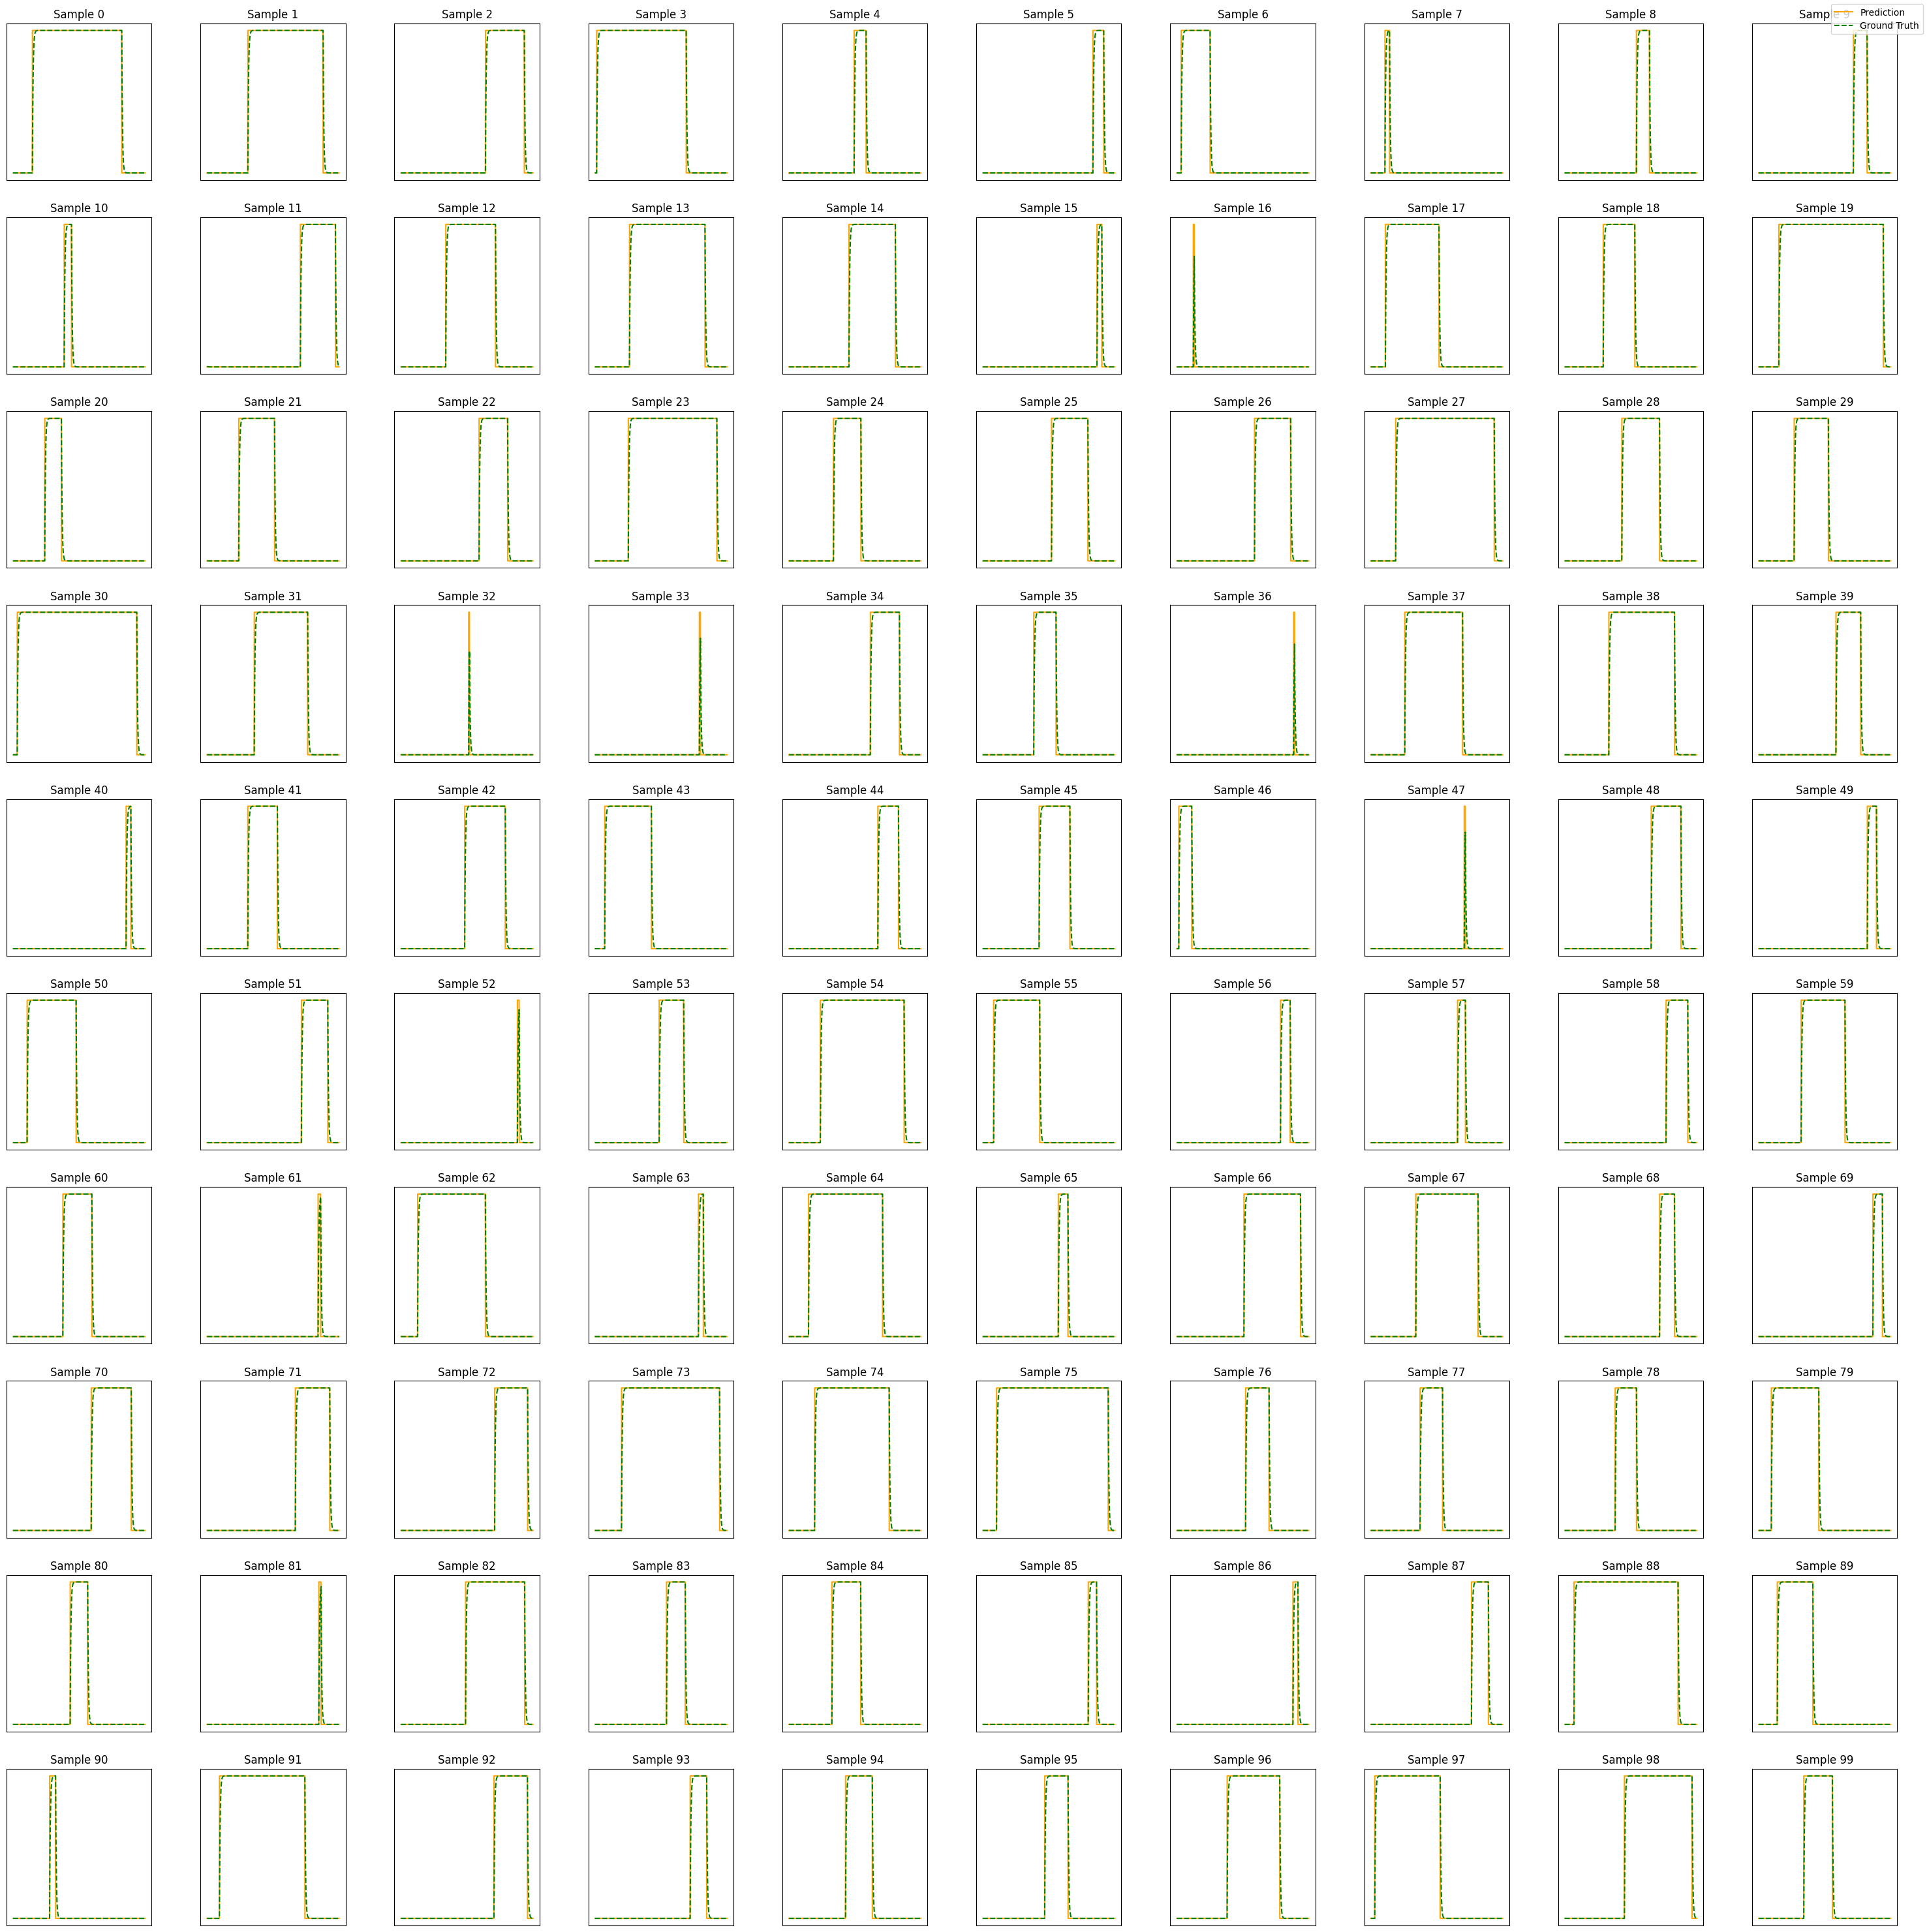

In [5]:
plot_pred_v_truth(time, input_signals[:, np.newaxis, :], output_signals[:, np.newaxis, :])

In [6]:
# Split data
train_x, train_y = input_signals[:1000], output_signals[:1000]
test_x,  test_y  = input_signals[1000:], output_signals[1000:]

# Directory
out_dir = "data/pulse_data"
os.makedirs(out_dir, exist_ok=True)

# File paths
files = {
    "train_x": train_x,
    "train_y": train_y,
    "test_x":  test_x,
    "test_y":  test_y,
}

# Save only if file does not already exist
for name, data in files.items():
    path = os.path.join(out_dir, f"{name}.csv")
    if os.path.exists(path):
        print(f"Skipped: {path} already exists.")
    else:
        pd.DataFrame(data).to_csv(path, index=False)
        print(f"Created: {path}")

Created: data/pulse_data\train_x.csv
Created: data/pulse_data\train_y.csv
Created: data/pulse_data\test_x.csv
Created: data/pulse_data\test_y.csv


## Generate other functions

In [8]:
samples = 4
num_of_coeffs = 3

phase = np.random.uniform(0 , 2 * np.pi, (samples, num_of_coeffs))
freqs = np.random.uniform(0 , 0.1, (samples, num_of_coeffs))
multipliers = np.random.uniform(-2 , 2, (samples, num_of_coeffs))

input_signals = np.zeros((16, len(time)))

for j in range(samples):
    for i in range(num_of_coeffs):
        input_signals[j] += multipliers[j, i] * np.sin(2 * np.pi * freqs[j, i] * time + phase[j, i])

# --- Sinusoidal pulses with different start times and durations ---
pulse_starts = [20, 50, 10, 100]      # start times in seconds for each sinusoidal signal
pulse_durations = [40, 30, 60, 50]    # durations in seconds for each sinusoidal signal
frequencies = [0.005, 0.005, 0.005, 0.005]  # Hz
amplitudes = [1, 0.8, 0.6, 0.4]

for i in range(4):
    # Compute half-period duration in seconds
    half_period = 0.5 / frequencies[i]
    pulse_samples = int(half_period / (time[1] - time[0]))

    # Choose start index for the pulse (can be different for each signal)
    start_idx = int(pulse_starts[i] / (time[1]-time[0]))
    end_idx = start_idx + pulse_samples
    end_idx = min(end_idx, N)

    # Generate time segment for this pulse
    t_pulse = time[start_idx:end_idx] - time[start_idx]  # shift so pulse starts at 0

    # Sinusoidal pulse starting at 0 and ending at 0 after half a period
    input_signals[4 + i, start_idx:end_idx] = amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * t_pulse)

# --- Triangular pulses with different start times and durations ---
tri_pulse_starts = [30, 70, 20, 120]
tri_pulse_durations = [50, 40, 60, 30]
tri_amplitudes = [1, 0.8, 0.6, 0.4]

for i in range(4):
    start_idx = int(tri_pulse_starts[i] / (time[1]-time[0]))
    end_idx = start_idx + int(tri_pulse_durations[i] / (time[1]-time[0]))
    end_idx = min(end_idx, N)
    tri_pulse = triang(end_idx - start_idx)
    input_signals[8+i, start_idx:end_idx] = tri_amplitudes[i] * tri_pulse

# --- Gaussian signals (centered at different times, different widths) ---
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

gaussian_mus = [40, 60, 80, 100]  # center of pulse in seconds
gaussian_sigmas = [7, 5, 4, 3]

for i in range(4):
    input_signals[12+i] = gaussian(time, mu=gaussian_mus[i], sigma=gaussian_sigmas[i])

output_signals = np.zeros_like(input_signals)

for i in range(16):
    u = np.fft.ifft(H_hat * np.fft.fft(input_signals[i]))
    output_signals[i] = u

C:\Users\mathi\AppData\Local\Temp\ipykernel_32508\2038196565.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  output_signals[i] = u


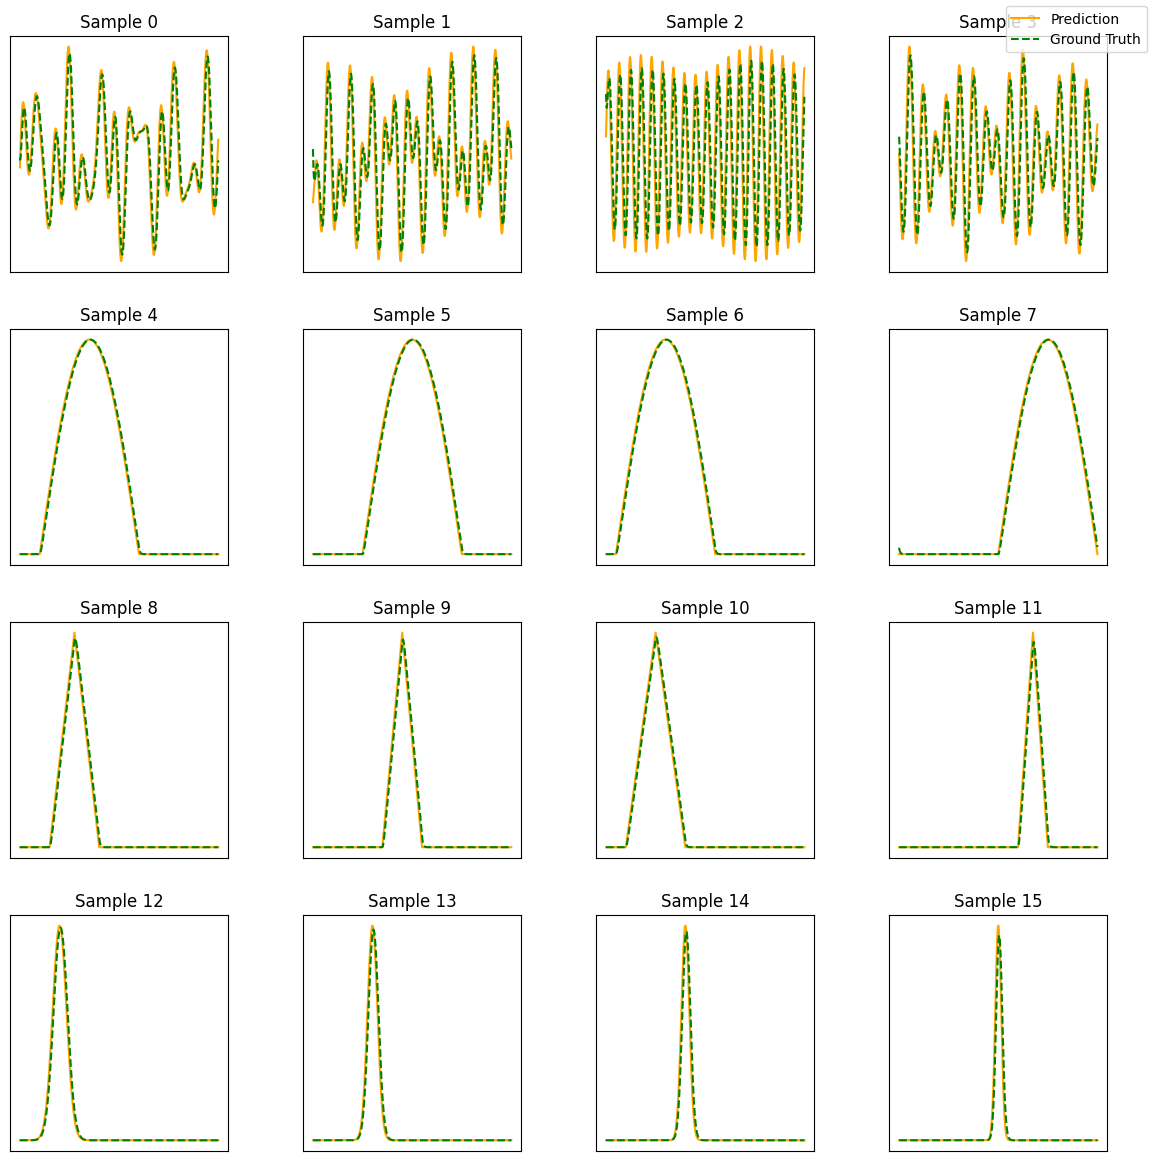

In [9]:
plot_pred_v_truth(time, input_signals[:, np.newaxis, :], output_signals[:, np.newaxis, :])

In [11]:
# File paths + data
files = {
    "outOfDist_x.csv": input_signals,
    "outOfDist_y.csv": output_signals,
}

for fname, data in files.items():
    path = os.path.join(out_dir, fname)
    if os.path.exists(path):
        print(f"Skipped: {path} already exists.")
    else:
        pd.DataFrame(data).to_csv(path, index=False)
        print(f"Created: {path}")

Created: data/pulse_data\outOfDist_x.csv
Created: data/pulse_data\outOfDist_y.csv
